In [2]:
# Bloque 0: imports y setup
import numpy as np
import pandas as pd
from tqdm import tqdm
import defs
import defs2
import funciones_aux
import matplotlib.pyplot as plt
import seaborn as sns
from funciones_aux import (
    eval_one_sim, bowley_skew, excess_kurtosis, 
    run_resumenes, run_tests, victorias_grouped, 
    columnas_comparacion_default
)

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# Bloque 3: loop principal de simulación (1000)

S = 1000
rows = []
for s in tqdm(range(1, S+1)):
    rows.append(eval_one_sim(s, rng))

df_ab = pd.DataFrame(rows)

print("✅ Simulaciones completadas:", len(df_ab))
print("Columnas:", list(df_ab.columns))
df_ab.head()

# Bloque 4: Resumen de victorias para recorte unilateral
comparisons_left = [
    ("d_mp1_vs_mean_left",   "V1 vs Media (izq)"),
    ("d_mp2_vs_mean_left",   "V2 vs Media (izq)"),
    ("d_mp1_vs_median_left", "V1 vs Mediana (izq)"),
    ("d_mp2_vs_median_left", "V2 vs Mediana (izq)"),
    ("d_v2_vs_v1_left",      "V2 vs V1 (izq)")
]
comparisons_right = [
    ("d_mp1_vs_mean_right",   "V1 vs Media (der)"),
    ("d_mp2_vs_mean_right",   "V2 vs Media (der)"),
    ("d_mp1_vs_median_right", "V1 vs Mediana (der)"),
    ("d_mp2_vs_median_right", "V2 vs Mediana (der)"),
    ("d_v2_vs_v1_right",      "V2 vs V1 (der)")
]

# Resumen global de victorias (proporciones y diferencias promedio)
df_resumenes_left = run_resumenes(df_ab, comparisons_left, threshold=0.0)
df_resumenes_right = run_resumenes(df_ab, comparisons_right, threshold=0.0)
print("--- Resumen de recorte izquierda ---")
display(df_resumenes_left)
print("\n--- Resumen de recorte derecha ---")
display(df_resumenes_right)


  5%|▍         | 46/1000 [01:05<22:41,  1.43s/it]



KeyboardInterrupt: 

In [ ]:
# Bloque 4: Resumen de victorias por subgrupos para recorte unilateral
cols_diffs_left = ["d_mp1_vs_mean_left", "d_mp2_vs_mean_left", "d_v2_vs_v1_left"]
cols_diffs_right = ["d_mp1_vs_mean_right", "d_mp2_vs_mean_right", "d_v2_vs_v1_right"]

victorias_familia_left   = victorias_grouped(df_ab, "familia",       cols_diffs_left, threshold=0.0)
victorias_familia_right  = victorias_grouped(df_ab, "familia",       cols_diffs_right, threshold=0.0)
victorias_outliers_left  = victorias_grouped(df_ab, "tuvo_outliers", cols_diffs_left, threshold=0.0)
victorias_outliers_right = victorias_grouped(df_ab, "tuvo_outliers", cols_diffs_right, threshold=0.0)
victorias_rango_n_left   = victorias_grouped(df_ab, "rango_n",       cols_diffs_left, threshold=0.0)
victorias_rango_n_right  = victorias_grouped(df_ab, "rango_n",       cols_diffs_right, threshold=0.0)

print("--- Proporción de victorias por familia (izquierda) ---")
display(victorias_familia_left)
print("\n--- Proporción de victorias por familia (derecha) ---")
display(victorias_familia_right)

print("\n--- Proporción de victorias por outliers (izquierda) ---")
display(victorias_outliers_left)
print("\n--- Proporción de victorias por outliers (derecha) ---")
display(victorias_outliers_right)

print("\n--- Proporción de victorias por rango_n (izquierda) ---")
display(victorias_rango_n_left)
print("\n--- Proporción de victorias por rango_n (derecha) ---")
display(victorias_rango_n_right)


,comparacion,proporcion,casos_gana,total,media_diff,mediana_diff
0,V1 vs Media,0.635,635,1000,0.013634,1.673777e-03
1,V2 vs Media,0.613,613,1000,0.026840,3.162294e-03
2,V1 vs Mediana,0.000,0,1000,-0.086579,-4.257832e-02
3,V2 vs Mediana,0.000,0,1000,-0.073373,-3.802022e-02
4,V2 vs V1,0.568,568,1000,0.013206,5.640627e-14


In [ ]:
# Proporciones de victorias por subgrupos
cols_diffs = [c for c, _ in comparisons]

victorias_familia   = victorias_grouped(df_ab, "familia",       cols_diffs, threshold=0.0)
victorias_outliers  = victorias_grouped(df_ab, "tuvo_outliers", cols_diffs, threshold=0.0)
victorias_rango_n   = victorias_grouped(df_ab, "rango_n",       cols_diffs, threshold=0.0)

print("--- Proporción de victorias por familia ---")
display(victorias_familia)

print("\n--- Proporción de victorias por outliers ---")
display(victorias_outliers)

print("\n--- Proporción de victorias por rango_n ---")
display(victorias_rango_n)


--- Proporción de victorias por familia ---


,familia,d_mp1_vs_mean,d_mp2_vs_mean,d_mp1_vs_median,d_mp2_vs_median,d_v2_vs_v1
0,beta,0.670807,0.602484,0.0,0.0,0.546584
1,gamma,0.633094,0.683453,0.0,0.0,0.647482
2,lognormal,0.892857,0.914286,0.0,0.0,0.542857
3,mixtura_bimodal,0.631206,0.595745,0.0,0.0,0.439716
4,normal,0.410959,0.363014,0.0,0.0,0.630137
5,t_student,0.489796,0.503401,0.0,0.0,0.578231
6,uniforme,0.738095,0.650794,0.0,0.0,0.595238



--- Proporción de victorias por outliers ---


,tuvo_outliers,d_mp1_vs_mean,d_mp2_vs_mean,d_mp1_vs_median,d_mp2_vs_median,d_v2_vs_v1
0,False,0.645299,0.598291,0.0,0.0,0.542735
1,True,0.610738,0.647651,0.0,0.0,0.627517



--- Proporción de victorias por rango_n ---


,rango_n,d_mp1_vs_mean,d_mp2_vs_mean,d_mp1_vs_median,d_mp2_vs_median,d_v2_vs_v1
0,grande,0.475309,0.503086,0.0,0.0,0.669753
1,mediano,0.618619,0.597598,0.0,0.0,0.708709
2,pequeño,0.801749,0.731778,0.0,0.0,0.335277


In [ ]:
# Tests estadísticos (Wilcoxon unilateral) para recorte unilateral
comparisons_left = [
    ("d_mp1_vs_mean_left",   "V1 vs Media (izq)"),
    ("d_mp2_vs_mean_left",   "V2 vs Media (izq)"),
    ("d_mp1_vs_median_left", "V1 vs Mediana (izq)"),
    ("d_mp2_vs_median_left", "V2 vs Mediana (izq)"),
    ("d_v2_vs_v1_left",      "V2 vs V1 (izq)")
]
comparisons_right = [
    ("d_mp1_vs_mean_right",   "V1 vs Media (der)"),
    ("d_mp2_vs_mean_right",   "V2 vs Media (der)"),
    ("d_mp1_vs_median_right", "V1 vs Mediana (der)"),
    ("d_mp2_vs_median_right", "V2 vs Mediana (der)"),
    ("d_v2_vs_v1_right",      "V2 vs V1 (der)")
]

df_tests_left = run_tests(df_ab, comparisons_left, alternative="greater")
df_tests_right = run_tests(df_ab, comparisons_right, alternative="greater")
print("--- Tests Wilcoxon recorte izquierda ---")
display(df_tests_left)
print("\n--- Tests Wilcoxon recorte derecha ---")
display(df_tests_right)


,comparacion,n,statistic,p_value,alternative
0,V1 vs Media,1000,287204.0,2.615328e-05,greater
1,V2 vs Media,1000,306780.0,3.048346e-10,greater
2,V1 vs Mediana,1000,0.0,1.000000e+00,greater
3,V2 vs Mediana,1000,0.0,1.000000e+00,greater
4,V2 vs V1,1000,266803.5,1.215063e-30,greater


In [ ]:
# (Opcional) Persistir tablas a CSV para el apéndice del experimento
df_resumenes.to_csv("ab_resumenes.csv", index=False)
victorias_familia.to_csv("ab_victorias_por_familia.csv", index=False)
victorias_outliers.to_csv("ab_victorias_por_outliers.csv", index=False)
victorias_rango_n.to_csv("ab_victorias_por_rangon.csv", index=False)
df_tests.to_csv("ab_tests_wilcoxon.csv", index=False)
print("CSV exportados ✅")


CSV exportados ✅


### Visualizaciones

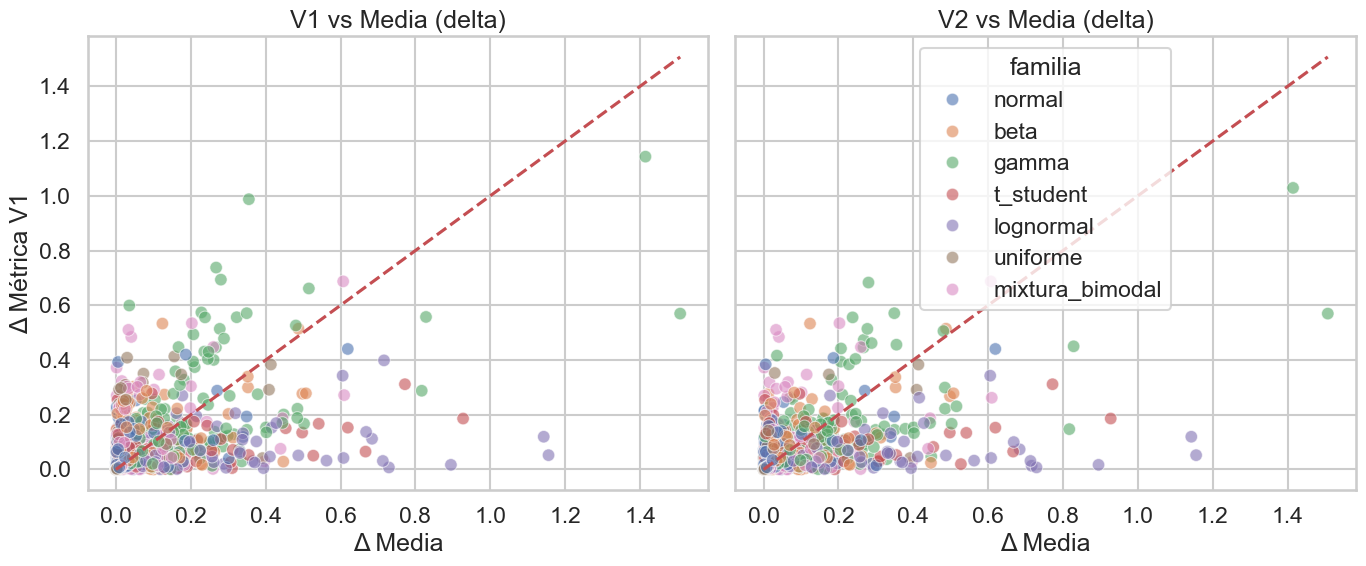

In [ ]:

# Configuración estética
sns.set(style="whitegrid", context="talk")

# --- 1. Dispersión: delta_mean vs delta_mp1 y delta_mp2 ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

sns.scatterplot(
    data=df_ab, x="delta_mean", y="delta_mp1",
    hue="familia", alpha=0.6, ax=axes[0], legend=False
)
axes[0].plot([0, df_ab[["delta_mean","delta_mp1"]].max().max()],
             [0, df_ab[["delta_mean","delta_mp1"]].max().max()],
             'r--')
axes[0].set_title("V1 vs Media (delta)")
axes[0].set_xlabel("Δ Media")
axes[0].set_ylabel("Δ Métrica V1")

sns.scatterplot(
    data=df_ab, x="delta_mean", y="delta_mp2",
    hue="familia", alpha=0.6, ax=axes[1]
)
axes[1].plot([0, df_ab[["delta_mean","delta_mp2"]].max().max()],
             [0, df_ab[["delta_mean","delta_mp2"]].max().max()],
             'r--')
axes[1].set_title("V2 vs Media (delta)")
axes[1].set_xlabel("Δ Media")
axes[1].set_ylabel("Δ Métrica V2")

plt.tight_layout()
plt.show()


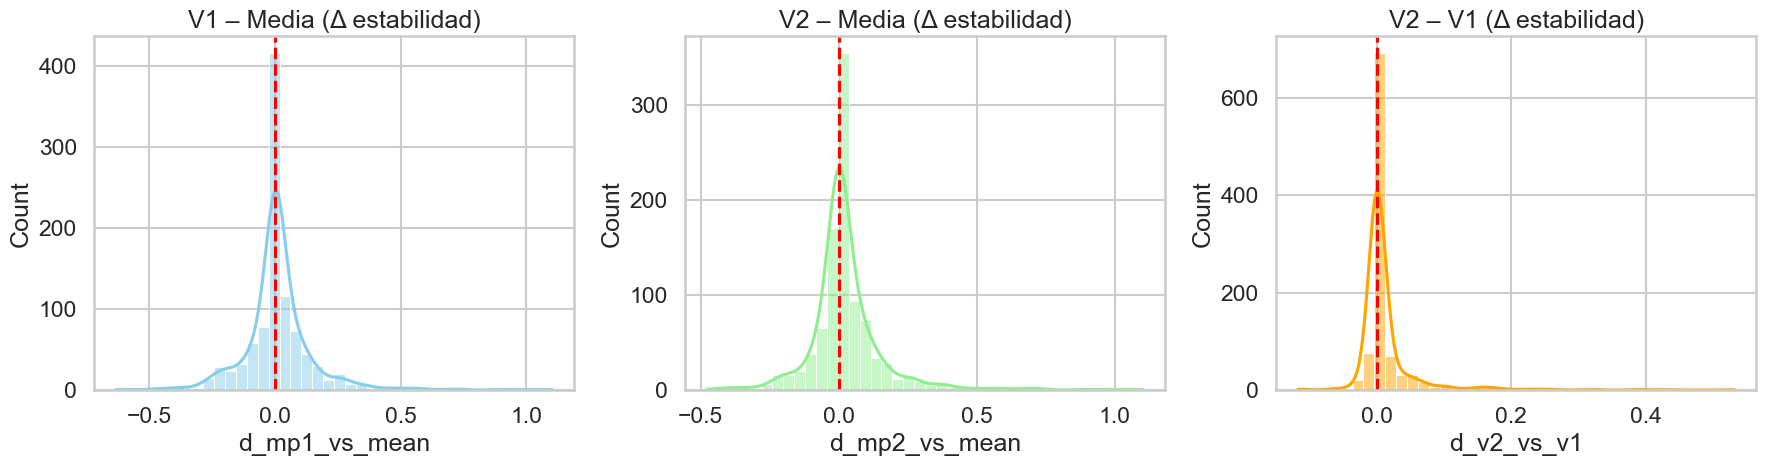

In [ ]:
# --- 2. Histograma de mejoras directas bajo recorte unilateral ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Izquierda
sns.histplot(df_ab["d_mp1_vs_mean_left"], bins=40, kde=True, ax=axes[0,0], color="skyblue")
axes[0,0].axvline(0, color="red", linestyle="--")
axes[0,0].set_title("V1 – Media (Δ estabilidad, izq)")

sns.histplot(df_ab["d_mp2_vs_mean_left"], bins=40, kde=True, ax=axes[0,1], color="lightgreen")
axes[0,1].axvline(0, color="red", linestyle="--")
axes[0,1].set_title("V2 – Media (Δ estabilidad, izq)")

sns.histplot(df_ab["d_v2_vs_v1_left"], bins=40, kde=True, ax=axes[0,2], color="orange")
axes[0,2].axvline(0, color="red", linestyle="--")
axes[0,2].set_title("V2 – V1 (Δ estabilidad, izq)")

# Derecha
sns.histplot(df_ab["d_mp1_vs_mean_right"], bins=40, kde=True, ax=axes[1,0], color="skyblue")
axes[1,0].axvline(0, color="red", linestyle="--")
axes[1,0].set_title("V1 – Media (Δ estabilidad, der)")

sns.histplot(df_ab["d_mp2_vs_mean_right"], bins=40, kde=True, ax=axes[1,1], color="lightgreen")
axes[1,1].axvline(0, color="red", linestyle="--")
axes[1,1].set_title("V2 – Media (Δ estabilidad, der)")

sns.histplot(df_ab["d_v2_vs_v1_right"], bins=40, kde=True, ax=axes[1,2], color="orange")
axes[1,2].axvline(0, color="red", linestyle="--")
axes[1,2].set_title("V2 – V1 (Δ estabilidad, der)")

plt.tight_layout()
plt.show()


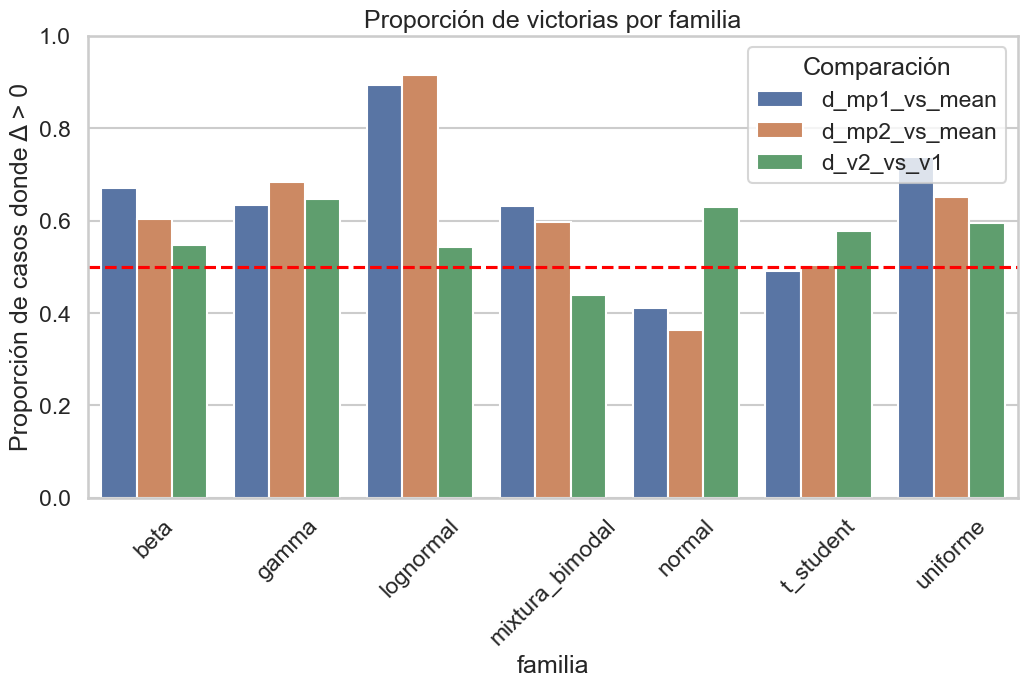

In [ ]:
# --- 3. Proporciones de victorias por familia bajo recorte unilateral ---
cols_diffs_left = ["d_mp1_vs_mean_left", "d_mp2_vs_mean_left", "d_v2_vs_v1_left"]
cols_diffs_right = ["d_mp1_vs_mean_right", "d_mp2_vs_mean_right", "d_v2_vs_v1_right"]

prop_fam_left = (
    df_ab.groupby("familia")[cols_diffs_left]
         .apply(lambda g: (g > 0).mean())
         .reset_index()
         .melt(id_vars="familia", var_name="comparacion", value_name="prop_victorias")
)
prop_fam_right = (
    df_ab.groupby("familia")[cols_diffs_right]
         .apply(lambda g: (g > 0).mean())
         .reset_index()
         .melt(id_vars="familia", var_name="comparacion", value_name="prop_victorias")
)

plt.figure(figsize=(12, 6))
sns.barplot(data=prop_fam_left, x="familia", y="prop_victorias", hue="comparacion")
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Proporción de victorias por familia (recorte izquierda)")
plt.ylabel("Proporción de casos donde Δ > 0")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Comparación")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=prop_fam_right, x="familia", y="prop_victorias", hue="comparacion")
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Proporción de victorias por familia (recorte derecha)")
plt.ylabel("Proporción de casos donde Δ > 0")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="Comparación")
plt.show()


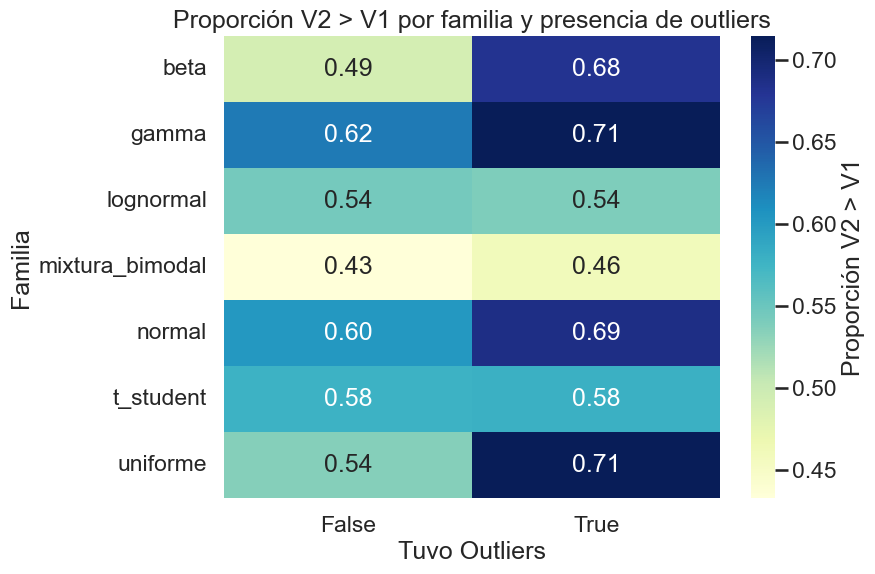

In [ ]:
# --- 4. Heatmap de victorias por (familia x outliers) bajo recorte unilateral ---
heat_data_left = (
    df_ab.groupby(["familia", "tuvo_outliers"])["d_v2_vs_v1_left"]
         .apply(lambda x: (x > 0).mean())
         .unstack()
)
heat_data_right = (
    df_ab.groupby(["familia", "tuvo_outliers"])["d_v2_vs_v1_right"]
         .apply(lambda x: (x > 0).mean())
         .unstack()
)

plt.figure(figsize=(8, 6))
sns.heatmap(heat_data_left, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Proporción V2 > V1 (izq)'})
plt.title("Proporción V2 > V1 por familia y presencia de outliers (recorte izquierda)")
plt.ylabel("Familia")
plt.xlabel("Tuvo Outliers")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(heat_data_right, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Proporción V2 > V1 (der)'})
plt.title("Proporción V2 > V1 por familia y presencia de outliers (recorte derecha)")
plt.ylabel("Familia")
plt.xlabel("Tuvo Outliers")
plt.show()
